In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
!kaggle datasets download -d edifonjimmy/lipnet-dataset

Dataset URL: https://www.kaggle.com/datasets/edifonjimmy/lipnet-dataset
License(s): MIT
 95% 384M/404M [00:04<00:00, 86.8MB/s]
100% 404M/404M [00:04<00:00, 89.1MB/s]


In [ ]:
!unzip /content/lipnet-dataset.zip

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, " ", line[2]]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), shape=[-1]))

In [ ]:
def load_data(path:str):
    path  = bytes.decode(path.numpy())

    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join("/content/data",'s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content/data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '/content/data/s1/bbaf2n.mpg'

In [ ]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames.shape ,alignments.shape

(TensorShape([75, 46, 140, 1]), TensorShape([22]))

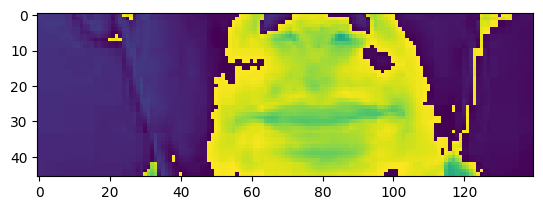

In [ ]:
plt.imshow(frames[0])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at f two now'>

In [ ]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files("/content/data/s1/*.mpg")
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
testx = data.as_numpy_iterator()

In [ ]:
val = testx.next(); val[0]

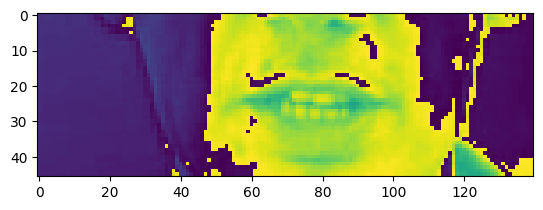

In [ ]:
plt.imshow(val[0][0][40])

In [ ]:
directory = 'animations'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")

Directory 'animations' created successfully.


In [ ]:
video_frames = val[0][1]

video_frames = np.squeeze(video_frames)

num_frames, height, width = video_frames.shape
video_frames_uint8 = (video_frames * 255).astype(np.uint8)
video_frames_reshaped = np.reshape(video_frames_uint8, (num_frames, height, width))

output_path = "/content/animations/animation.gif"
imageio.mimsave('/content/animations/animation.gif', video_frames_reshaped, fps=10)

print(f"Animation saved successfully to: {output_path}")

Animation saved successfully to: /content/animations/animation.gif


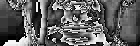

In [ ]:
from IPython.display import Image

# Specify the path to the saved GIF
gif_path = '/content/animations/animation.gif'

# Display the GIF
Image(filename=gif_path, width=400, height=300 , )

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' lay white at r seven soon'>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=(75, 40, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


# model.add(TimeDistributed(Flatten()))
model.add(Reshape(( 75, -1)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)                    │ (None, 75, 40, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 75, 40, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 75, 20, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 75, 20, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 75, 20, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 75, 10, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 75, 10, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 75, 10, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


<tf.Tensor: shape=(), dtype=string, numpy=b'xxhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh11'>

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class produce_example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTC_loss)

In [ ]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = produce_example(test)

In [ ]:
model.fit(train,validation_data = test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Original:  lay red in k three soon
Prediction:  e e e e n no
Original:  lay red with l four now
Prediction:  e e e e n no
450/450 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - loss: 102.2175 - val_loss: 72.0996 - learning_rate: 1.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Original:  bin red at m three soon
Prediction:  le e e e e ea
Original:  bin red in f five soon
Prediction:  l e e e e eo
450/450 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - loss: 73.0976 - val_loss: 65.9877 - learning_rate: 1.0000e-04
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Original:  place green by k nine again
Prediction:  la e e e e o
Original:  lay red by r four now
Prediction:  la e e e e eo
450/450 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - loss: 68.4246 - val_loss: 62.6076 - learning_rate: 1.0000e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Original:  lay white with m three again
Prediction:  la e e t e eon
Original:  place sp blue with x zero now
Predictio

In [ ]:
test_data = test.as_numpy_iterator()
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b' place green in d four now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' lay red with s zero please'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' pla e o'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' pla e o'>]